# **IRWA_LAB_PART1**

# **0. LOADINGS**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
import nltk
nltk.download('stopwords')

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json

import string
import re

import pandas as pd

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
docs_path = '/content/drive/MyDrive/RIAW/IRWA_data_2024/data/farmers-protest-tweets.json'
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

tweets = [json.loads(line.strip()) for line in lines]

In [4]:
print("Total number of tweets : {}".format(len(tweets)))

Total number of tweets : 117407


# **1. TEXT PROCESSING**

### **TRANSLATION HINDI TO ENGLISH  (NOT REQUIRED TO EXECUTE)**

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
#as a 1st step, we translate hindi tweets to english, as they are heavily important in this dataset we do not want to get rid of them
#we consider them as english tweets after translation to make our life easier, adding a tag to each tweet of the language of the tweet originally

from googletrans import Translator


translator = Translator()

def translate_tweet_add_lang_tag(tweet_text):

    detected_lang = translator.detect(tweet_text).lang #detecting the language

    if detected_lang != 'en':
        translated_text = translator.translate(tweet_text, dest='en').text
    else:
        translated_text = tweet_text  #we don't do anything if it was english

    return translated_text, detected_lang

In [ ]:
progress = 0
translated_tweets = tweets

for tweet in translated_tweets:

    if progress % 10000 == 0:
        print(f"processed {progress} tweets")

    translated_text, detected_language = translate_tweet_add_lang_tag(tweet['content'])

    tweet['content'] = translated_text #updating the content into english
    tweet['language'] = detected_language #adding the column with the language of the tweet

    progress += 1


In [ ]:
tweets[69]['content']

'ਹਾਰਦੇ ਨੀ ਹੁੰਦੇ ਕਦੇ ਮਰਦ ਦਲੇਰ 👍👍\n#FarmersProtest\n#ModiDontSellFarmers https://t.co/5AhZfZ9YPB'

In [ ]:
translated_tweets[69]['content']

'Brave men never lose\n#FarmersProtest\n#ModiDontSellFarmers https://t.co/5AhZfZ9YPB'

In [ ]:
#Save translated tweets
import json

with open('/content/drive/MyDrive/RIAW/IRWA_data_2024/data/translated_tweets.json', 'w', encoding='utf-8') as f:
    json.dump(translated_tweets, f, ensure_ascii=False, indent=4)

### **TO OPEN THE FILE WITH THE TRANSLATED TWEETS**

In [7]:
with open('/content/drive/MyDrive/RIAW/IRWA_data_2024/data/translated_tweets.json', 'r', encoding='utf-8') as f:
    translated_tweets = json.load(f)

#translated_tweets[3]

In [8]:
print(tweets[69]['content']) #example before translation

ਹਾਰਦੇ ਨੀ ਹੁੰਦੇ ਕਦੇ ਮਰਦ ਦਲੇਰ 👍👍
#FarmersProtest
#ModiDontSellFarmers https://t.co/5AhZfZ9YPB


In [10]:
print(translated_tweets[69]['content']) #example after translation

Brave men never lose
#FarmersProtest
#ModiDontSellFarmers https://t.co/5AhZfZ9YPB


### **FUNCTION TO PRE-PROCESS THE DOCUMENTS AND PRE-PROCESSING OF ORIGINAL AND TRANSLATED**

In [11]:
def build_terms(line):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line = re.sub(r"http\S+|www\S+|https\S+", '', line, flags=re.MULTILINE)  #remove URLs

    line = line.lower() #lowercase

    tokens = line.split() #tokenize


    processed_tokens = []
    for token in tokens:

        if token.startswith('#'):
            processed_tokens.append(token) #keep hasthags exactly as they are
        else:
            token = token.translate(str.maketrans('', '', string.punctuation)) #remove punctuations

            if token and token not in stop_words: #eliminate the stopwords
                stemmed_token = stemmer.stem(token) #stemming
                processed_tokens.append(stemmed_token)

    return processed_tokens

In [12]:
terms_of_each_tweet = []

for tweet in tweets:
    terms_of_each_tweet.append(build_terms(tweet['content']))

In [13]:
#example
print(terms_of_each_tweet[1])

['#farmersprotest', '#modiignoringfarmersdeaths', '#modidontsellfarmers', 'kisanektamorcha', 'farmer', 'constantli', 'distroy', 'crop', 'throughout', 'india', 'realli', 'heart', 'breakingw', 'care', 'crop', 'like', 'children', 'govt', 'agricultur', 'minist', 'laugh', 'us🚜🌾w', 'win💪']


In [14]:
#Cretae terms for the translated tweets
terms_of_each_translated_tweet = []

for tweet in translated_tweets:
    terms_of_each_translated_tweet.append(build_terms(tweet['content']))

In [15]:
print(terms_of_each_translated_tweet[69])

['brave', 'men', 'never', 'lose', '#farmersprotest', '#modidontsellfarmers']


## **Bidirectional Mapping for the tweet’s Ids with the document ids for evaluation**

In [16]:
docs_path_map = '/content/drive/MyDrive/RIAW/IRWA_data_2024/data/tweet_document_ids_map.csv'

df = pd.read_csv(docs_path_map)


doc_to_tweet_map = dict(zip(df['docId'], df['id']))  #map doc to tweet id

tweet_to_doc_map = dict(zip(df['id'], df['docId']))  #map tweet_id to doc


doc_id = 'doc_0'
tweet_id = doc_to_tweet_map.get(doc_id)
print(f"doc_id {doc_id} have id {tweet_id}")


doc_id_10 = tweet_to_doc_map.get(1364505314586951680)
print(f"doc_id {doc_id_10} have id {1364505314586951680}")

doc_id doc_0 have id 1364506249291784198
doc_id doc_10 have id 1364505314586951680


# **2. RETURN Tweet | Date | Hashtags| Likes | Retweets | Url | id | clean terms**

FOR ORIGINAL TWEETS

In [17]:
import re

filtered_tweets = []
i = 0

for tweet in tweets:

    content = tweet['content']
    date = tweet['date']
    likes = tweet['likeCount']
    retweets = tweet['retweetCount']
    url = tweet['url']
    id = tweet['id']

    #creating new column for the hasthags + need to find them
    hashtags = re.findall(r'#\w+', content)

    filtered_tweet = {
        'Content': content,
        'Date': date,
        'Hashtags': hashtags,
        'Likes': likes,
        'Retweets': retweets,
        'Url': url,
        'id': id,
        'clean terms': terms_of_each_tweet[i]
    }

    filtered_tweets.append(filtered_tweet)

    i += 1




In [18]:
filtered_tweets[0]

{'Content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF',
 'Date': '2021-02-24T09:23:35+00:00',
 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'],
 'Likes': 0,
 'Retweets': 0,
 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198',
 'id': 1364506249291784198,
 'clean terms': ['world',
  'progress',
  'indian',
  'polic',
  'govt',
  'still',
  'tri',
  'take',
  'india',
  'back',
  'horrif',
  'past',
  'tyranni',
  'narendramodi',
  'delhipolic',
  'shame',
  '#modidontsellfarmers',
  '#farmersprotest',
  '#freenodeepkaur']}

FOR TRANSALTED TWEETS

In [19]:
import re

filtered_translated_tweets = []
i = 0

# Iterar sobre los translated_tweets y terms_of_each_translated_tweet
for tweet in translated_tweets:

    content = tweet['content']
    date = tweet['date']
    likes = tweet['likeCount']
    retweets = tweet['retweetCount']
    url = tweet['url']
    id = tweet['id']

    # Crear nueva columna para los hashtags (encontrar hashtags en el tweet traducido)
    hashtags = re.findall(r'#\w+', content)

    # Crear el tweet filtrado con los términos del tweet traducido
    filtered_tweet = {
        'Content': content,
        'Date': date,
        'Hashtags': hashtags,
        'Likes': likes,
        'Retweets': retweets,
        'Url': url,
        'id': id,
        'clean terms': terms_of_each_translated_tweet[i]  # Asignar términos traducidos
    }

    filtered_translated_tweets.append(filtered_tweet)

    i += 1  # Incrementar el índice para recorrer terms_of_each_translated_tweet


In [20]:
filtered_translated_tweets[69]  #See example with a tweed that originaly was in hindi

{'Content': 'Brave men never lose\n#FarmersProtest\n#ModiDontSellFarmers https://t.co/5AhZfZ9YPB',
 'Date': '2021-02-24T09:09:54+00:00',
 'Hashtags': ['#FarmersProtest', '#ModiDontSellFarmers'],
 'Likes': 1,
 'Retweets': 1,
 'Url': 'https://twitter.com/KaurAma57668156/status/1364502803125702658',
 'id': 1364502803125702658,
 'clean terms': ['brave',
  'men',
  'never',
  'lose',
  '#farmersprotest',
  '#modidontsellfarmers']}

# **3. EXPLORATORY DATA ANALYSIS**

**GENERAL STATISTICS FOR ORIGINAL TWEETS**

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


all_terms = [term for tweet_terms in terms_of_each_tweet for term in tweet_terms] #list with all terms
word_counts = Counter(all_terms)

most_common_words = word_counts.most_common(10)  #top10

In [ ]:
def count_words(text):
    return len(text.split())

In [ ]:
total_words = sum(word_counts.values())
unique_words = len(word_counts)
avg_terms_per_tweet = total_words / len(terms_of_each_tweet)
word_counts = [count_words(tweet['Content']) for tweet in filtered_tweets]
average_sentence_length = sum(word_counts) / len(word_counts)

print("Total number of tweets : {}".format(len(tweets)))
print(f"Total Words: {total_words}")
print(f"Vocabulary Size: {unique_words}")
print(f"Average Clean Terms Per Tweet: {avg_terms_per_tweet:.2f}")
print(f"Average Sentence Length (in words): {average_sentence_length:.2f}")

Total number of tweets : 117407
Total Words: 1554093
Vocabulary Size: 123278
Average Clean Terms Per Tweet: 13.24
Average Sentence Length (in words): 17.05


**WORD DISTRIBUTION**

In [ ]:
most_common_words

[('#farmersprotest', 116705),
 ('farmer', 16544),
 ('के', 9751),
 ('है', 8857),
 ('की', 7334),
 ('में', 7254),
 ('support', 6685),
 ('india', 6486),
 ('#releasedetainedfarmers', 5960),
 ('किसान', 5774)]

**As we can see some of the most common words in the tweets are in hindi so we are going to do some data analysis of the transaled tweet to undestand better the data**

In [ ]:
all_translated_terms = [term for tweet_terms in terms_of_each_translated_tweet for term in tweet_terms]  # lista con todos los términos
word_counts_translated = Counter(all_translated_terms)

most_common_translated_words = word_counts_translated.most_common(10)  # top 10

def count_words(text):
    return len(text.split())

total_translated_words = sum(word_counts_translated.values())
unique_translated_words = len(word_counts_translated)
avg_terms_per_translated_tweet = total_translated_words / len(terms_of_each_translated_tweet)


translated_word_counts = [count_words(tweet['Content']) for tweet in filtered_translated_tweets]
average_translated_sentence_length = sum(translated_word_counts) / len(translated_word_counts)

print("Total number of translated tweets: {}".format(len(translated_tweets)))
print(f"Total Translated Words: {total_translated_words}")
print(f"Vocabulary Size (Translated): {unique_translated_words}")
print(f"Average Clean Terms Per Translated Tweet: {avg_terms_per_translated_tweet:.2f}")
print(f"Average Sentence Length (in words) for Translated Tweets: {average_translated_sentence_length:.2f}")

most_common_translated_words

Total number of translated tweets: 117407
Total Translated Words: 1306838
Vocabulary Size (Translated): 78501
Average Clean Terms Per Translated Tweet: 11.13
Average Sentence Length (in words) for Translated Tweets: 17.05


[('#farmersprotest', 116329),
 ('farmer', 27548),
 ('support', 7776),
 ('india', 7279),
 ('protest', 6088),
 ('#releasedetainedfarmers', 5884),
 ('peopl', 5779),
 ('govern', 5738),
 ('#farmersmakeindia', 5189),
 ('#mahapanchayatrevolution', 4793)]

**HISTOGRAM FOR TERMS OF ORIGINAL TWEETS**

<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  plt.tight_layout()
<ipython-input-20-7260a5b40acc>:21: UserWarning: G

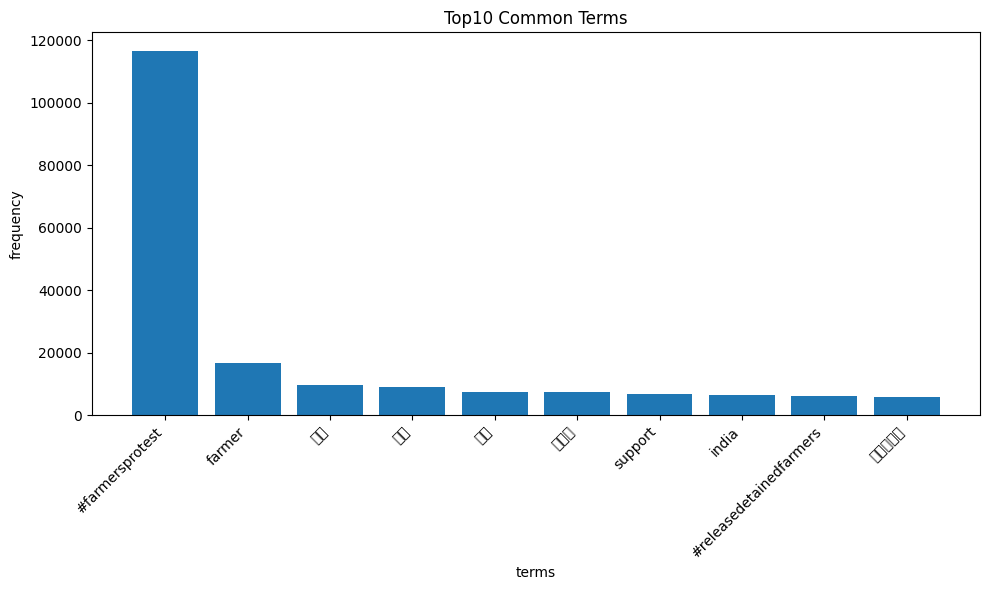

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


all_terms = [term for tweet_terms in terms_of_each_tweet for term in tweet_terms] #list with all terms
word_counts = Counter(all_terms)

most_common_words = word_counts.most_common(10)  #top10


words, counts = zip(*most_common_words)

#plot histogram
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top10 Common Terms')
plt.ylabel('frequency')
plt.xlabel('terms')
plt.tight_layout()
plt.show()


**HISTOGRAM FOR TERMS OF TRANSLATED TWEETS**

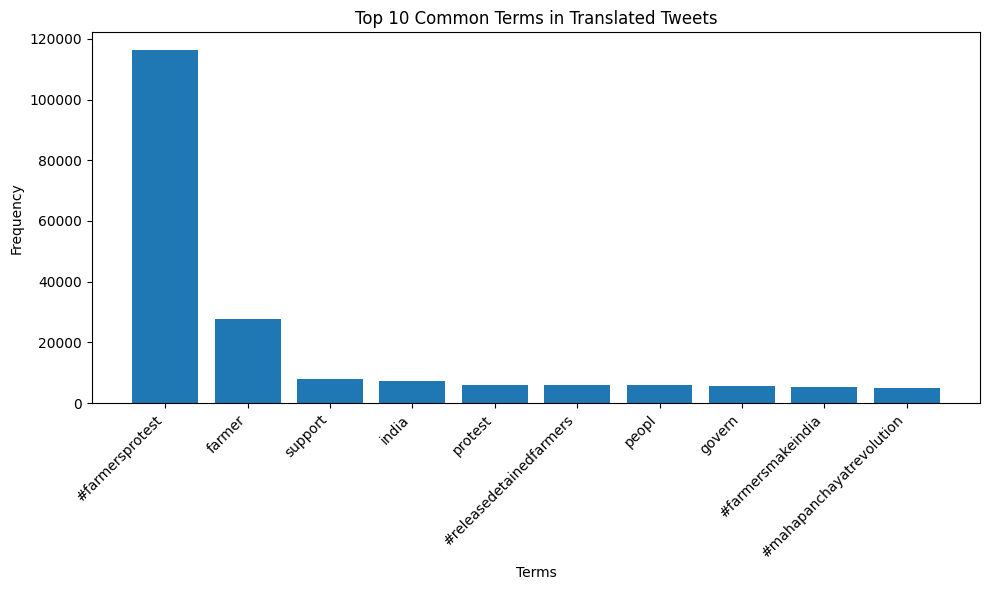

In [ ]:
all_translated_terms = [term for tweet_terms in terms_of_each_translated_tweet for term in tweet_terms]  # lista con todos los términos
translated_word_counts = Counter(all_translated_terms)

most_common_translated_words = translated_word_counts.most_common(10)  # top 10

# Separar palabras y cuentas
translated_words, translated_counts = zip(*most_common_translated_words)

# Plotear histograma
plt.figure(figsize=(10, 6))
plt.bar(translated_words, translated_counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Common Terms in Translated Tweets')
plt.ylabel('Frequency')
plt.xlabel('Terms')
plt.tight_layout()
plt.show()

**MOST RETWEETED**

In [22]:
most_retweeted_tweets = sorted(filtered_tweets, key=lambda x: x['Retweets'], reverse=True) #sorting with most to less retweeted

top_n = 10

print(f"Top {top_n} Most Retweeted Tweets:")
for i, tweet in enumerate(most_retweeted_tweets[:top_n], 1):
    print(f"\nTOP {i}:")
    print(f"Retweets: {tweet['Retweets']}")
    print(f"Content: {tweet['Content']}")
    print(f"URL: {tweet['Url']}")


Top 10 Most Retweeted Tweets:

TOP 1:
Retweets: 7723
Content: मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
URL: https://twitter.com/RakeshTikaitBKU/status/1360169510079111173

TOP 2:
Retweets: 6164
Content: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
URL: https://twitter.com/dhruv_rathee/status/1364148079117615105

TOP 3:
Retweets: 4673
Content: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ
U

**MOST RETWEETED TRANSLATED**

In [23]:
most_retweeted_tweets = sorted(filtered_translated_tweets, key=lambda x: x['Retweets'], reverse=True) #sorting with most to less retweeted

top_n = 10

print(f"Top {top_n} Most Retweeted Tweets:")
for i, tweet in enumerate(most_retweeted_tweets[:top_n], 1):
    print(f"\nTOP {i}:")
    print(f"Retweets: {tweet['Retweets']}")
    print(f"Content: {tweet['Content']}")
    print(f"URL: {tweet['Url']}")


Top 10 Most Retweeted Tweets:

TOP 1:
Retweets: 7723
Content: In Madhya Pradesh, a private trader ran away after purchasing paddy worth Rs 200 crore. Farmers are protesting for money.
I still have to tell you what black is.
#FarmLaws #FarmersProtest #Kisan_Ekta_Zindabad
URL: https://twitter.com/RakeshTikaitBKU/status/1360169510079111173

TOP 2:
Retweets: 6164
Content: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
URL: https://twitter.com/dhruv_rathee/status/1364148079117615105

TOP 3:
Retweets: 4673
Content: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedi

**HASTHAGS DISTRIBUTION**

In [ ]:
all_hashtags = []

for tweet in filtered_tweets:
    all_hashtags.extend( tweet['Hashtags'])

hashtag_counts = Counter(all_hashtags) #counting frequency
most_common_hashtags = hashtag_counts.most_common(10) #top10

print("Top 10 Hashtags + occurrences\n")
for hashtag in most_common_hashtags:
    print(hashtag)


Top 10 Hashtags + occurrences

('#FarmersProtest', 112630)
('#ReleaseDetainedFarmers', 5987)
('#FarmersMakeIndia', 5263)
('#farmersprotest', 5105)
('#MahapanchayatRevolution', 4735)
('#RepealOnlyWayAhead', 4511)
('#IndiaBeingSilenced', 4332)
('#FarmersProtests', 3661)
('#Pagdi_Sambhal_Jatta', 3542)
('#DishaRavi', 3017)


**WORDCLOUD WITH TOP 50 MOST USED HASHTAGS**

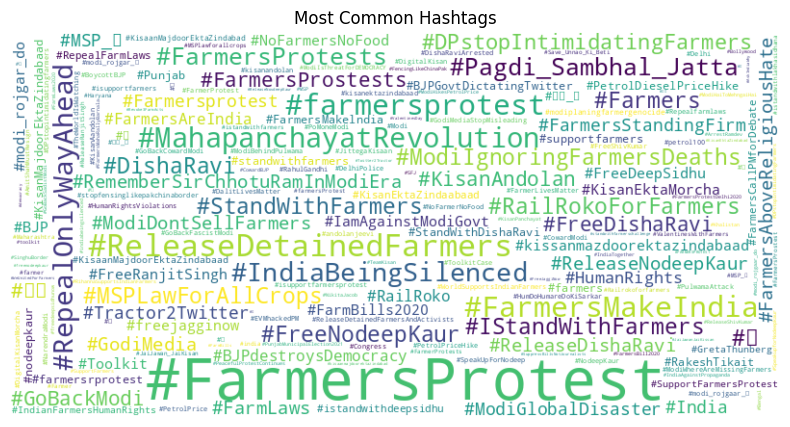

In [ ]:
from wordcloud import WordCloud

hashtag_dict = dict(hashtag_counts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_dict)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Hashtags")
plt.show()


**WORD CLOUD FOR TOP 50 NON-HASHTAG CLEAN TERMS**

*FOR ORIGINAL TWEETS*

In [ ]:
all_terms = []

for tweet in filtered_tweets:
    terms = tweet['clean terms']
    terms_without_hastag = [term for term in terms if not term.startswith('#')]
    all_terms.extend(terms_without_hastag)

term_counts = Counter(all_terms) #counting frequency
most_common_termss = term_counts.most_common(50) #top50 for wordcloud

print("Top 10 non-hashtag clean terms + occurrences\n")
i = 0
for term in most_common_termss:
    if i <= 10:
        print(term)
        i += 1
    else:
        break

Top 10 non-hashtag clean terms + occurrences

('farmer', 16544)
('के', 9751)
('है', 8857)
('की', 7334)
('में', 7254)
('support', 6685)
('india', 6486)
('किसान', 5774)
('को', 5734)
('का', 5685)
('protest', 4961)


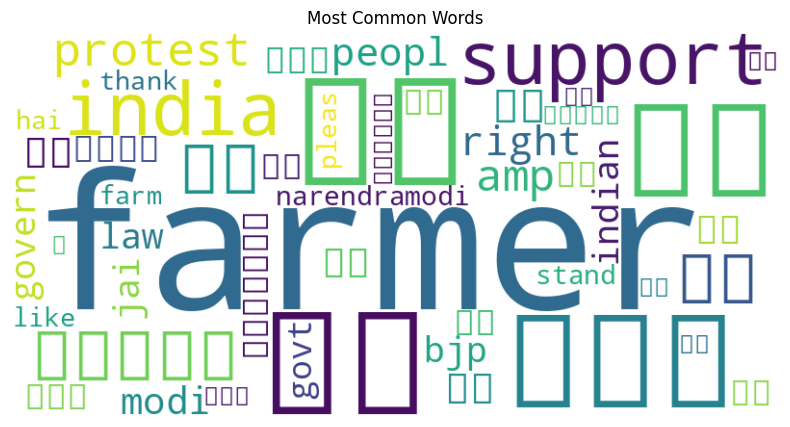

In [ ]:
term_dict = dict(most_common_termss)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words")
plt.show()


*NOW FOR ALL THE TWEETS TRANSLATED*

Top 10 non-hashtag clean terms + occurrences

('farmer', 27548)
('support', 7776)
('india', 7279)
('protest', 6088)
('peopl', 5779)
('govern', 5738)
('modi', 4778)
('right', 4665)
('law', 4272)
('amp', 4047)


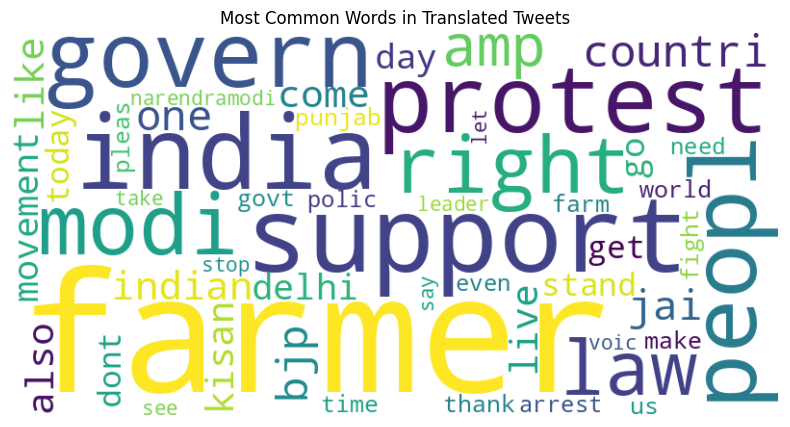

In [ ]:
all_translated_terms = []

for tweet in filtered_translated_tweets:
    terms = tweet['clean terms']  # Asegúrate de que esta clave contenga los términos de los tweets traducidos
    terms_without_hashtag = [term for term in terms if not term.startswith('#')]  # Filtrar los hashtags
    all_translated_terms.extend(terms_without_hashtag)  # Agregar términos a la lista

translated_term_counts = Counter(all_translated_terms)

most_common_translated_terms = translated_term_counts.most_common(50)

print("Top 10 non-hashtag clean terms + occurrences\n")
for i, term in enumerate(most_common_translated_terms):
    if i < 10:  # Cambiado de <= a < para evitar la última iteración
        print(term)

translated_term_dict = dict(most_common_translated_terms)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(translated_term_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Translated Tweets")
plt.show()

**ENTITY RECOGNITION**

In [24]:
#We install spacy, to have the needed rules for entity recognition
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:
import spacy

#load the pre-trained English model from spaCy
nlp = spacy.load("en_core_web_sm")

In [41]:
def extract_entities_without_hashtags(text):
    #remove hashtags
    text_without_hashtags = re.sub(r'#\w+', '', text)

    doc = nlp(text_without_hashtags)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    return entities

**FOR TWEETS**

In [42]:
#add recognized entities to each tweet
for tweet in filtered_tweets:
    content = tweet['Content']
    entities = extract_entities_without_hashtags(content)
    tweet['Entities'] = entities

#example for first 5
for tweet in filtered_tweets[:5]:
    print(f"Tweet: {tweet['Content']}")
    print(f"Entities: {tweet['Entities']}")
    print('-' * 80)

Tweet: The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF
Entities: [('Indian', 'NORP'), ('Govt', 'ORG'), ('India', 'GPE')]
--------------------------------------------------------------------------------
Tweet: #FarmersProtest 
#ModiIgnoringFarmersDeaths 
#ModiDontSellFarmers 
@Kisanektamorcha 
Farmers constantly distroying crops throughout India. 
Really, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE
Entities: [('@Kisanektamorcha \nFarmers', 'PERSON'), ('India', 'GPE'), ('🚜', 'GPE'), ('https://t.co/kLspngG9xE', 'GPE')]
--------------------------------------------------------------------------------
Tweet: ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ 
ਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜ

**MOST USED ENTITIES FOR TWEETS**

In [43]:
all_entities_with_labels = []

for tweet in filtered_tweets:
    entities = tweet['Entities']
    all_entities_with_labels.extend(entities)

#count appearances
entity_label_counts = Counter(all_entities_with_labels)

#top10
most_common_entities_with_labels = entity_label_counts.most_common(10)

print("Top 10 Most Common Entities with Labels:\n")
for entity, count in most_common_entities_with_labels:
    print(f"{entity[0]} ({entity[1]}): {count}")


Top 10 Most Common Entities with Labels:

India (GPE): 5606
भी (NORP): 2216
🚜 (GPE): 2027
🙏 (ORG): 1975
Indian (NORP): 1878
हैं (PERSON): 1625
Farmers (ORG): 1586
BJP (ORG): 1463
Delhi (GPE): 1275
🙏 (GPE): 1124


**MOST USED ENTITY TYPES FOR TWEETS**

In [44]:
entity_counter = Counter()

for tweet in filtered_tweets:
    for entity in tweet['Entities']:
        entity_counter[entity[1]] += 1

#top10 entity types
print("Top 10 Entity Types:")
for entity, count in entity_counter.most_common(10):
    print(f"{entity}: {count}")


Top 10 Entity Types:
PERSON: 55680
ORG: 49155
GPE: 30470
CARDINAL: 16356
NORP: 12988
DATE: 8565
PRODUCT: 7028
WORK_OF_ART: 2080
FAC: 1590
LOC: 1319


**FOR TRANSLATED_TWEETS**

In [38]:
for tweet in filtered_translated_tweets:
    content = tweet['Content']  # Original content of the tweet
    entities = extract_entities_without_hashtags(content)  # Run NER without hashtags
    tweet['Entities'] = entities  # Add entities to the tweet

for tweet in filtered_translated_tweets[:5]:
    print(f"Tweet: {tweet['Content']}")
    print(f"Entities (without hashtags): {tweet['Entities']}")
    print('-' * 80)

Tweet: The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF
Entities (without hashtags): [('Indian', 'NORP'), ('Govt', 'ORG'), ('India', 'GPE')]
--------------------------------------------------------------------------------
Tweet: #FarmersProtest 
#ModiIgnoringFarmersDeaths 
#ModiDontSellFarmers 
@Kisanektamorcha 
Farmers constantly distroying crops throughout India. 
Really, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE
Entities (without hashtags): [('@Kisanektamorcha \nFarmers', 'PERSON'), ('India', 'GPE'), ('🚜', 'GPE'), ('https://t.co/kLspngG9xE', 'GPE')]
--------------------------------------------------------------------------------
Tweet: Keeping in mind the prices of petro

**MOST USED ENTITY TYPES FOR TRANSLATED_TWEETS**

In [39]:
all_entities_with_labels = []

for tweet in filtered_translated_tweets:
    entities = tweet['Entities']
    all_entities_with_labels.extend(entities)

#count appearances
entity_label_counts = Counter(all_entities_with_labels)

#top10
most_common_entities_with_labels = entity_label_counts.most_common(10)

print("Top 10 Most Common Entities with Labels For Translated Tweets: \n")
for entity, count in most_common_entities_with_labels:
    print(f"{entity[0]} ({entity[1]}): {count}")


Top 10 Most Common Entities with Labels:
India (GPE): 6333
BJP (ORG): 2563
Delhi (GPE): 2199
Indian (NORP): 2051
Farmers (ORG): 2027
🚜 (GPE): 1965
today (DATE): 1829
🙏 (ORG): 1828
Modi (GPE): 1211
🙏 (GPE): 1040


**MOST USED ENTITY TYPES FOR TRANSLATED_TWEETS**

In [40]:
entity_counter = Counter()

for tweet in filtered_translated_tweets:
    for entity in tweet['Entities']:
        entity_counter[entity[1]] += 1

#top10 entity types
print("Top 10 Entity Types For Translated Types: \n")
for entity, count in entity_counter.most_common(10):
    print(f"{entity}: {count}")


Top 10 Entity Types:
ORG: 41630
PERSON: 40068
GPE: 29509
CARDINAL: 13054
DATE: 11467
NORP: 8760
PRODUCT: 4016
WORK_OF_ART: 1662
LOC: 1401
TIME: 1397
